In [1]:
import tensorflow as tf

2024-08-05 08:39:13.197063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 08:39:13.197209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 08:39:13.318926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the paths
train_sketch_path = '/kaggle/input/sketchnew'
train_photo_path = '/kaggle/input/sketch-to-face-dataset'

# Load the datasets
batch_size = 32
img_size = (128, 128)

train_sketch_ds = image_dataset_from_directory(
    train_sketch_path,
    label_mode=None,
    image_size=img_size,
    batch_size=batch_size
)

train_photo_ds = image_dataset_from_directory(
    train_photo_path,
    label_mode=None,
    image_size=img_size,
    batch_size=batch_size
)

# Normalize the images to [-1, 1]
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

train_sketch_ds = train_sketch_ds.map(normalize)
train_photo_ds = train_photo_ds.map(normalize)

# Combine the datasets into a single dataset
train_ds = tf.data.Dataset.zip((train_sketch_ds, train_photo_ds))

# Prefetch for better performance
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 188 files.
Found 188 files.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256)  

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)




/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00042489]], shape=(1, 1), dtype=float32)


In [6]:
import tensorflow as tf

# Define the loss and optimizer
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 5000
noise_dim = 100
num_examples_to_generate = 16


accuracy_metric = tf.keras.metrics.BinaryAccuracy()

@tf.function
def train_step(sketch_images, photo_images):
    noise = tf.random.normal([sketch_images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(photo_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  
    accuracy_metric.update_state(tf.ones_like(real_output), real_output)
    accuracy_metric.update_state(tf.zeros_like(fake_output), fake_output)
    
    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        accuracy_metric.reset_state()  
        
        for sketch_images, photo_images in dataset:
            gen_loss, disc_loss = train_step(sketch_images, photo_images)

        accuracy = accuracy_metric.result().numpy()
        print(f'Epoch {epoch+1}, gen loss={gen_loss.numpy()}, disc loss={disc_loss.numpy()}, accuracy={accuracy}')

train(train_ds, EPOCHS)

def evaluate_accuracy(test_dataset):
    accuracy_metric.reset_state() 

    for sketch_images, photo_images in test_dataset:
        generated_images = generator(sketch_images, training=False)
        real_output = discriminator(photo_images, training=False)
        fake_output = discriminator(generated_images, training=False)

        accuracy_metric.update_state(tf.ones_like(real_output), real_output)
        accuracy_metric.update_state(tf.zeros_like(fake_output), fake_output)

    overall_accuracy = accuracy_metric.result().numpy()
    print(f'Overall accuracy: {overall_accuracy}')
    return overall_accuracy

overall_accuracy = evaluate_accuracy(test_ds)


2024-08-05 08:39:33.464319: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 1, gen loss=1.2818784713745117, disc loss=0.5942221879959106, accuracy=0.7154255509376526
Epoch 2, gen loss=2.503657817840576, disc loss=0.09912566840648651, accuracy=1.0
Epoch 3, gen loss=5.666494369506836, disc loss=0.018041973933577538, accuracy=1.0
Epoch 4, gen loss=4.867776393890381, disc loss=0.008217846043407917, accuracy=1.0
Epoch 5, gen loss=8.2910795211792, disc loss=0.0005458852974697948, accuracy=1.0
Epoch 6, gen loss=6.539456844329834, disc loss=0.0026173777878284454, accuracy=1.0
Epoch 7, gen loss=6.789774417877197, disc loss=0.001515101408585906, accuracy=1.0
Epoch 8, gen loss=7.941298484802246, disc loss=0.00040915916906669736, accuracy=1.0
Epoch 9, gen loss=9.564456939697266, disc loss=8.712437556823716e-05, accuracy=1.0
Epoch 10, gen loss=9.433835983276367, disc loss=9.870342182694003e-05, accuracy=1.0
Epoch 11, gen loss=9.914356231689453, disc loss=6.103795021772385e-05, accuracy=1.0
Epoch 12, gen loss=9.43686580657959, disc loss=0.00015986838843673468, accurac

NameError: name 'test_ds' is not defined

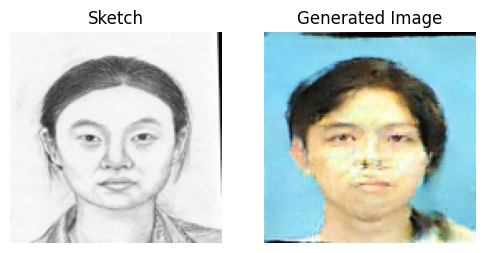

In [7]:
from PIL import Image


def load_and_preprocess_image(file_path):
    img = Image.open(file_path).convert('RGB')
    img = img.resize((128, 128))
    img = np.array(img) / 127.5 - 1.0  # Normalize to [-1, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def generate_image_from_sketch(file_path):
    sketch_image = load_and_preprocess_image(file_path)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    generated_image = (generated_image[0] + 1) / 2.0  # Rescale to [0, 1]

    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.title('Sketch')
    plt.imshow((sketch_image[0] + 1) / 2.0)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Image')
    plt.imshow(generated_image)
    plt.axis('off')
    plt.show()



# Example usage
sketch_url = '/kaggle/input/sketchnew/F2-036-01-sz1.jpg'
generate_image_from_sketch(sketch_url)
     


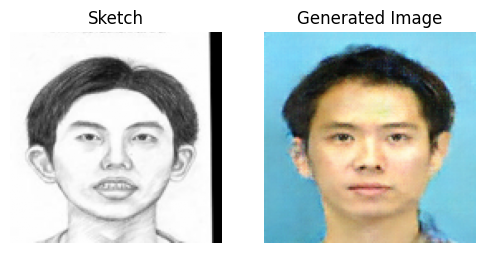

In [12]:
sketch_url = '/kaggle/input/sketchnew/M2-044-01-sz1.jpg'
generate_image_from_sketch(sketch_url)

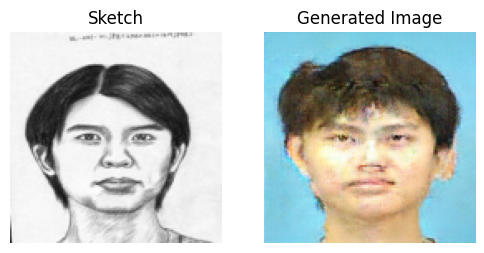

In [13]:
sketch_url = '/kaggle/input/sketchnew/m1-007-01-sz1.jpg'
generate_image_from_sketch(sketch_url)